In [101]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [102]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

Global Setting

In [103]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

# Read Data

In [104]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 50
        Cut_RHS = 120

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [105]:
lam_range_temp = [4800, 5300]   # Focus on optical region
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [106]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

In [107]:
sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [108]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

In [109]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal, norm_range=[4800, 5300])
# sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal)

In [110]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(Galaxy_info.ln_lam_gal, lam_range_temp, width=1000)
# nbins = np.unique(bin_num).size
# velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
# optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(Galaxy_info.ln_lam_gal)

# P2P solution

In [111]:
def Cube_sol(Galaxy_cube, redshift):
    
    plt.figure(figsize=(16, 3))
    ##-----------------------------------------------
    galaxies = np.ndarray(shape= (Galaxy_cube.spectra[:,0].shape[0],Galaxy_cube.cube.shape[1],Galaxy_cube.cube.shape[2]))
    # print(Galaxy_cube.cube.shape)
    for i in range(Galaxy_cube.cube.shape[1]):
        for j in range(Galaxy_cube.cube.shape[2]):
            # galaxy,logLam1,velscale = util.log_rebin(np.array([np.min(Galaxy_cube.wave), np.max(Galaxy_cube.wave)]),Galaxy_cube.cube[:,i,j])
            # galaxy = galaxy/np.median(galaxy)

            galaxies[:,i,j] = Galaxy_cube.spectra[:,i*max(Galaxy_cube.col)+j]
    # plt.plot(galaxies[:,10,20])

    # logLam10 = logLam1[:]
    # logLam1 = logLam10[200:-200]

    velscale_ratio = 2
    velscale = Galaxy_cube.velscale

    velfield = np.ndarray(shape=galaxies.shape[1:3])+np.nan
    sigfield = np.ndarray(shape=galaxies.shape[1:3])+np.nan
    tempnum = np.ndarray(shape=galaxies.shape[1:3])
    Bestfitfield = np.ndarray(shape=galaxies.shape)

    optimal_templates = np.ndarray(shape=(npix,galaxies.shape[1],galaxies.shape[2]))
    # pp_field = [[None]*Galaxy_cube.cube.shape[2]]*Galaxy_cube.cube.shape[1]
    # print(pp_field[0][1])

    for i in tqdm(range(galaxies.shape[1])):
        for j in range(galaxies.shape[2]):
            if(i == 11 and j == 38):
                plot_TF = True if (i == 11 and j == 38) else False
                tmpgalaxy = galaxies[:,i,j]
                noise = np.full_like(tmpgalaxy,0.1)
                noise = np.ones_like(tmpgalaxy)
                if np.count_nonzero(tmpgalaxy) > 50:
                    pp = ppxf(sps.templates, tmpgalaxy, noise, velscale, [vel_s, vel_dis_s],
                            plot=plot_TF, mask=mask0, lam=lam_gal, lam_temp=sps.lam_temp, quiet=not plot_TF)
                    # pp_field[i][j]=pp
                    Bestfitfield[:,i,j]=pp.bestfit

                    pp.optimal_template = sps.templates.reshape(sps.templates.shape[0], -1) @ pp.weights
                    optimal_templates[:,i,j] = pp.optimal_template
                    velfield[i,j] = pp.sol[0]
                    sigfield[i,j] = pp.sol[1]
                    weights = pp.weights
                    indwt = np.where(weights == np.max(weights))[0]
                    tempnum[i,j] = indwt[0]



    # i=11
    # j=43
    # plot_TF = True
    # tmpgalaxy = galaxies[:,i,j]
    # noise = np.full_like(tmpgalaxy,0.1)
    # noise = np.ones_like(tmpgalaxy)
    # # plt.plot(lam_gal,Galaxy_cube.spectra[:,i*max(Galaxy_cube.col)+j])
    # pp = ppxf(sps.templates, tmpgalaxy, noise, velscale, [vel_s, vel_dis_s],
    #           moments=2, degree=4, mdegree=-1,
    #           plot=False, mask=mask0, lam=lam_gal, lam_temp=sps.lam_temp, quiet=False)
    # pp.plot()
    # # plt.plot(tmpgalaxy)
    # velfield[i,j] = pp.sol[0]
    # sigfield[i,j] = pp.sol[1]
    # weights = pp.weights
    # indwt = np.where(weights == np.max(weights))[0]
    # tempnum[i,j] = indwt[0]
    # pp_field[i][j]=pp


    # return velfield, sigfield, pp_field
    return velfield, sigfield, Bestfitfield, optimal_templates

100%|██████████| 23/23 [00:00<00:00, 49.57it/s]

 Best Fit:       Vel     sigma
 comp.  0:        42        17
chi2/DOF: 33.31; DOF: 1696; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150


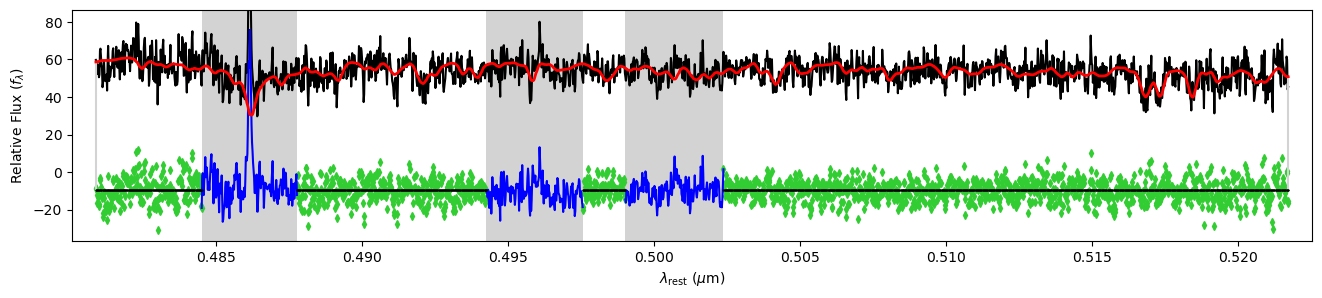

In [112]:
velfield, sigfield, Bestfitfield, optimal_templates = Cube_sol(Galaxy_info, redshift)

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\720897851.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


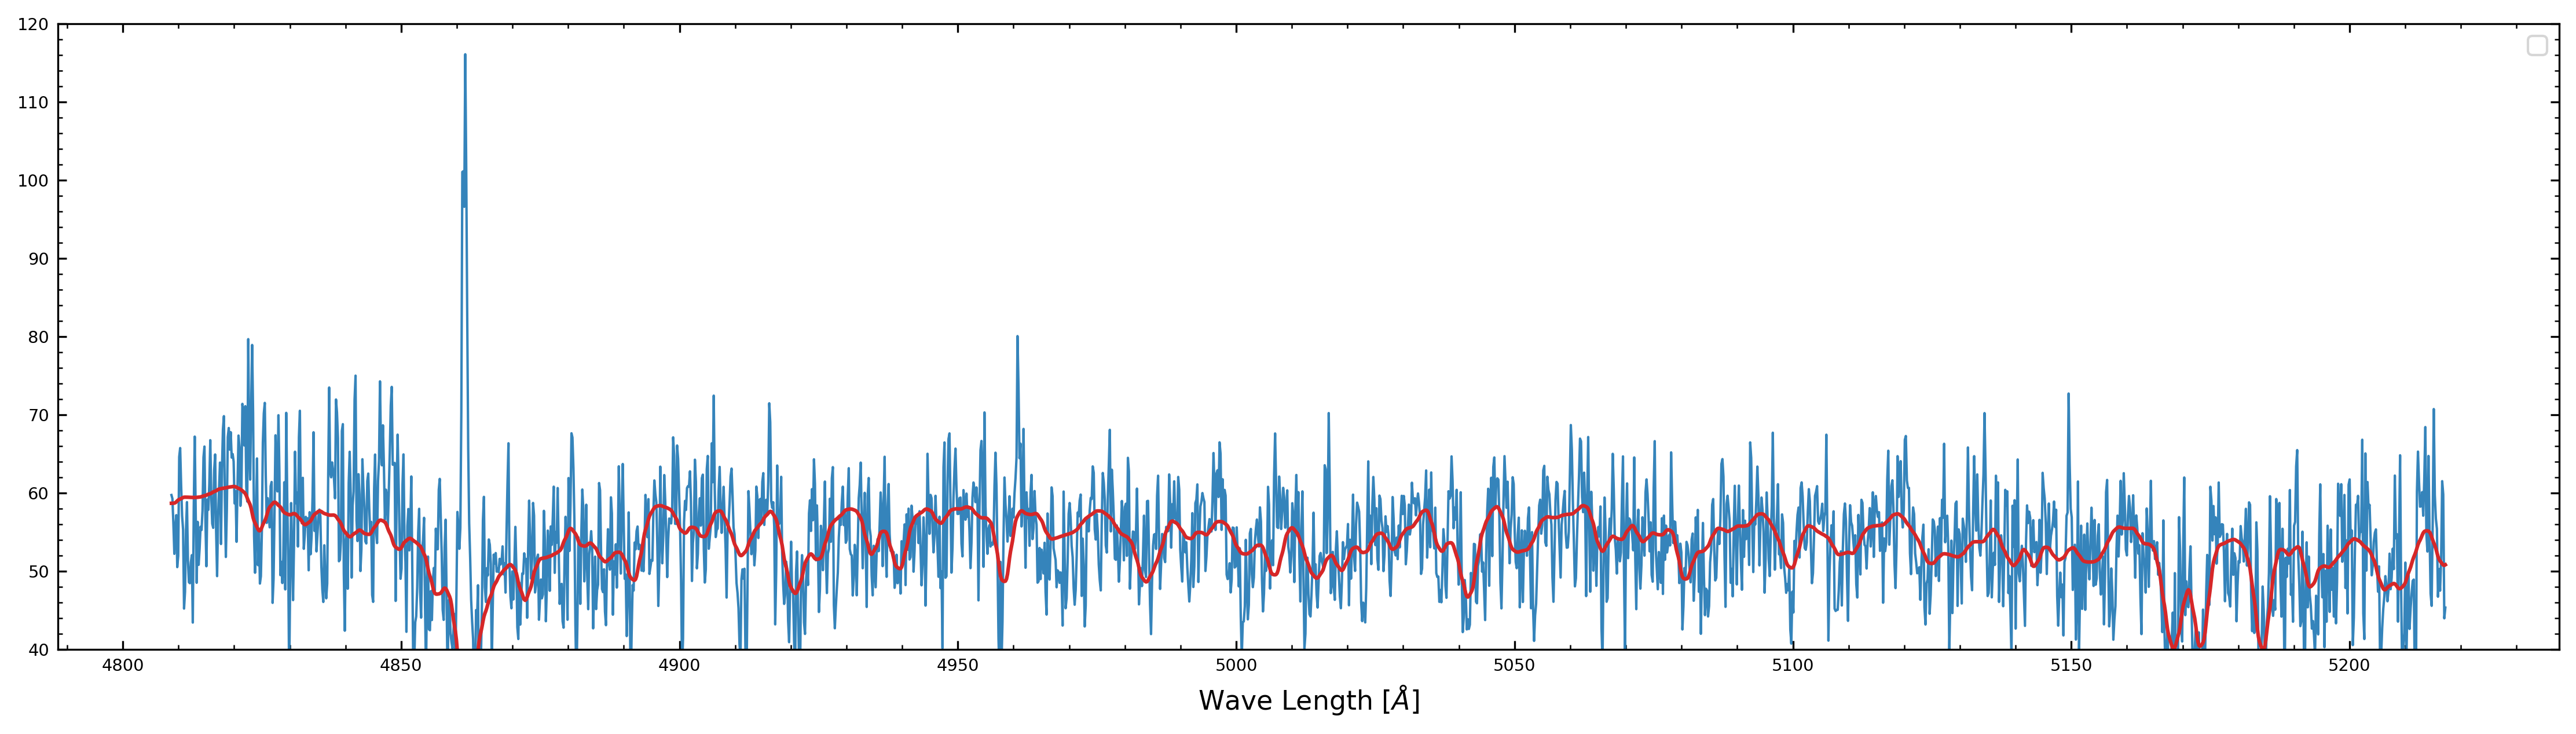

In [113]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,995], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,38], c='tab:red')


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(40,120)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [114]:
Index_Wave = pd.DataFrame({
        'Index':['H_beta','Fe_5015','Mg_b','Fe_5270','Fe_5270_s'],
        'BPC_range':[[4827.875,4847.875],[4946.500,4977.750],[5142.625,5161.375],[5233.150,5248.150],[5233.000,5250.000]],
        'CBP_range':[[4847.875,4876.625],[4977.750,5054.000],[5160.125,5192.625],[5245.650,5285.650],[5256.500,5278.500]],
        'RPC_range':[[4876.625,4891.625],[5054.000,5065.250],[5191.375,5206.375],[5285.650,5318.150],[5285.500,5308.000]]
})

In [115]:
Index_Wave

,Index,BPC_range,CBP_range,RPC_range
0,H_beta,"[4827.875, 4847.875]","[4847.875, 4876.625]","[4876.625, 4891.625]"
1,Fe_5015,"[4946.5, 4977.75]","[4977.75, 5054.0]","[5054.0, 5065.25]"
2,Mg_b,"[5142.625, 5161.375]","[5160.125, 5192.625]","[5191.375, 5206.375]"
3,Fe_5270,"[5233.15, 5248.15]","[5245.65, 5285.65]","[5285.65, 5318.15]"
4,Fe_5270_s,"[5233.0, 5250.0]","[5256.5, 5278.5]","[5285.5, 5308.0]"


In [116]:
Index_use = [0,1,2,4]

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\3694498050.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


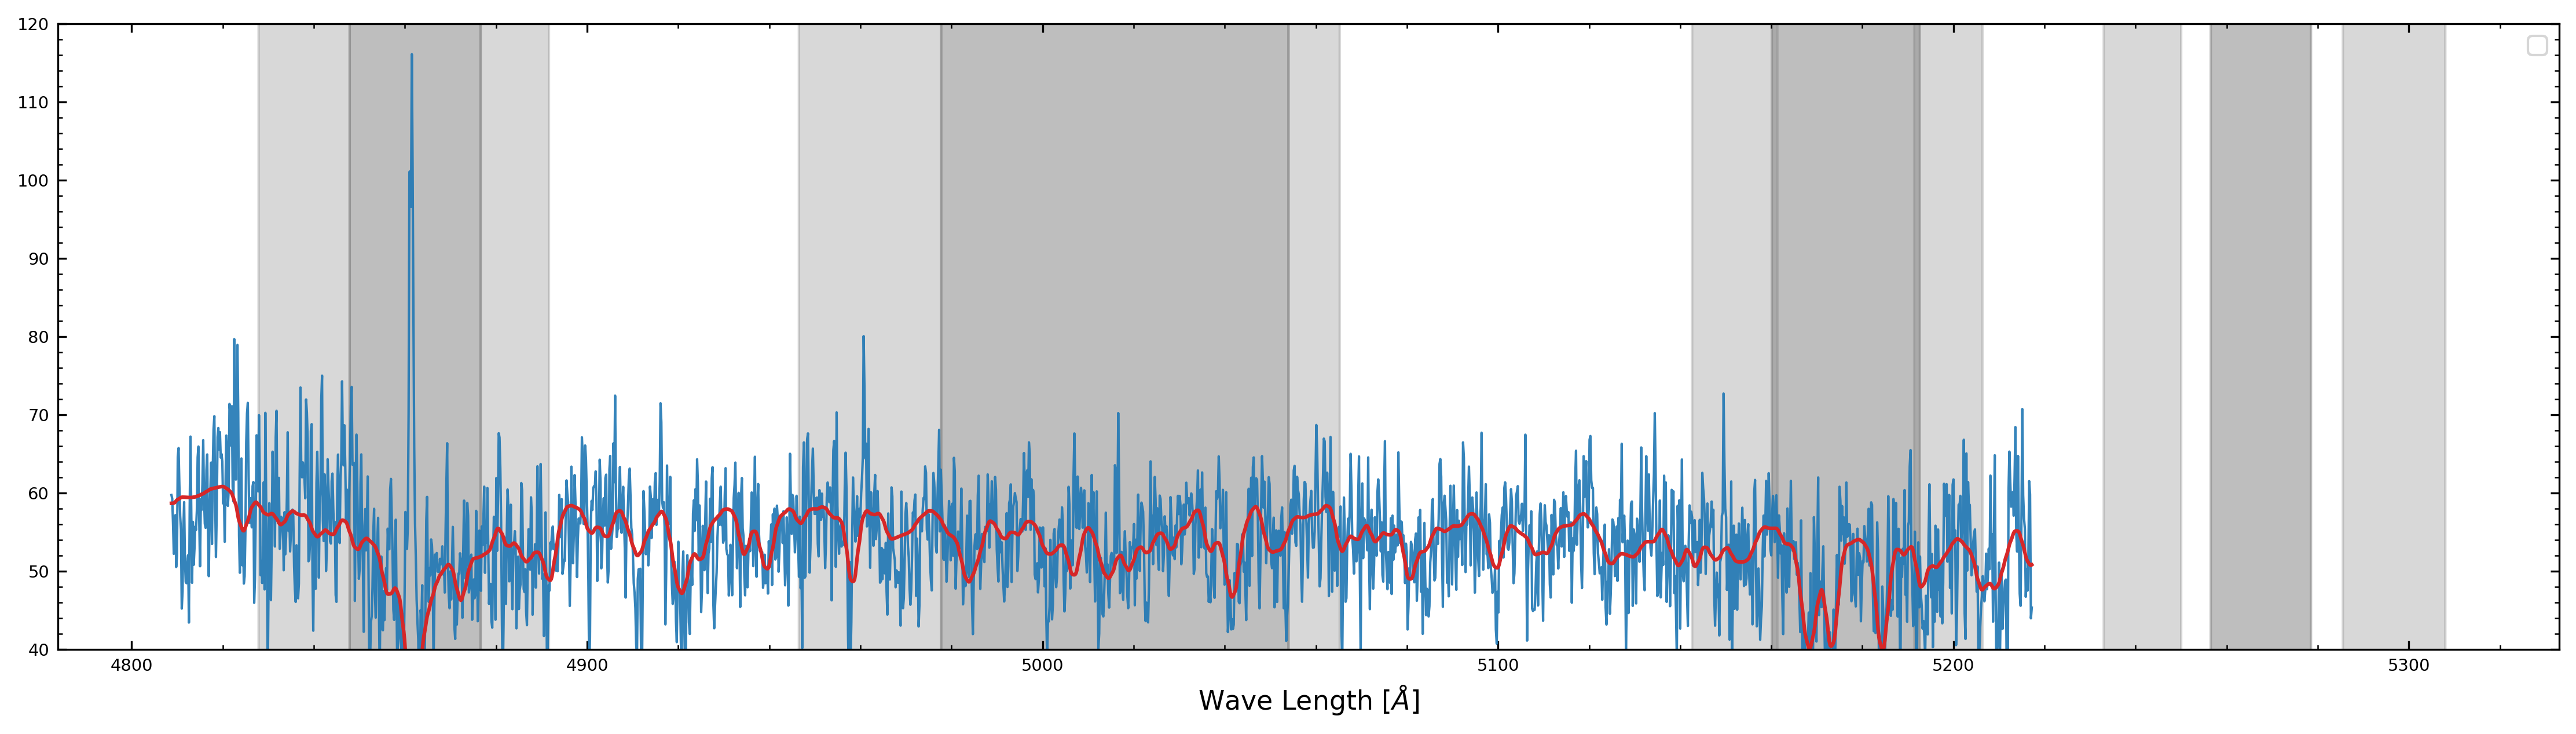

In [117]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,995], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,38], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(40,120)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\2464406390.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


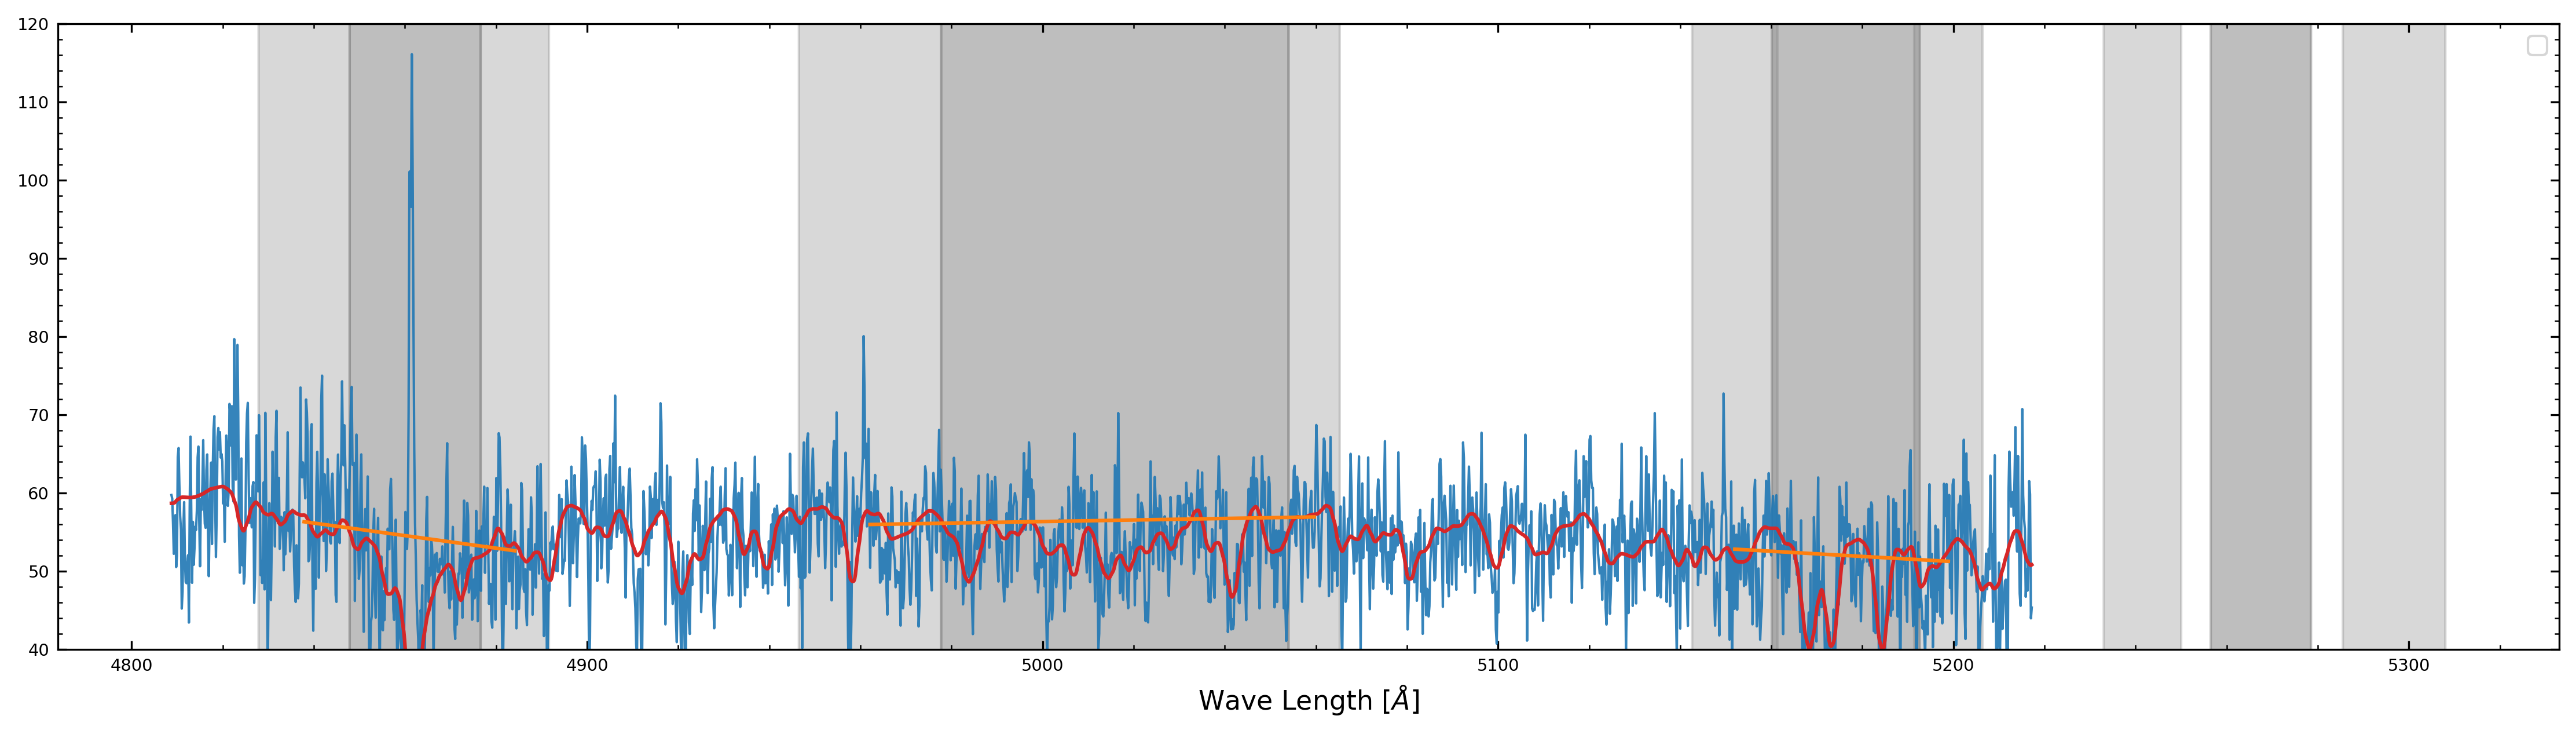

In [118]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,995], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,38], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)

for i in Index_use:
    LP = np.mean([Index_Wave.loc[i,'BPC_range'][0],Index_Wave.loc[i,'BPC_range'][1]])
    RP = np.mean([Index_Wave.loc[i,'RPC_range'][0],Index_Wave.loc[i,'RPC_range'][1]])
    LPV = np.mean(Bestfitfield[:,11,38][ np.where((lam_gal>Index_Wave.loc[i,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'BPC_range'][1])) ])
    RPV = np.mean(Bestfitfield[:,11,38][ np.where((lam_gal>Index_Wave.loc[i,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'RPC_range'][1])) ])
    ax1.plot([LP,RP], [LPV,RPV], lw=1.5, c='tab:orange')


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(40,120)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [119]:
H_Beta_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])

In [120]:
LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])

In [121]:
x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

In [122]:
for i in range(H_Beta_map.shape[0]):
    for j in range(H_Beta_map.shape[1]):

        LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])
        LCB = Index_Wave.loc[0,'CBP_range'][0]
        RCB = Index_Wave.loc[0,'CBP_range'][1]
        LPV = np.mean(Bestfitfield[:,i,j][ np.where((lam_gal>Index_Wave.loc[0,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'BPC_range'][1])) ])
        RPV = np.mean(Bestfitfield[:,i,j][ np.where((lam_gal>Index_Wave.loc[0,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i,j] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i,j] = Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i,j] = x_wave[:,i,j] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        H_Beta_map[i,j] = np.trapz(y_SL[:,i,j] - y_spectrum[:,i,j], x_wave[:,i,j])

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\2449161573.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


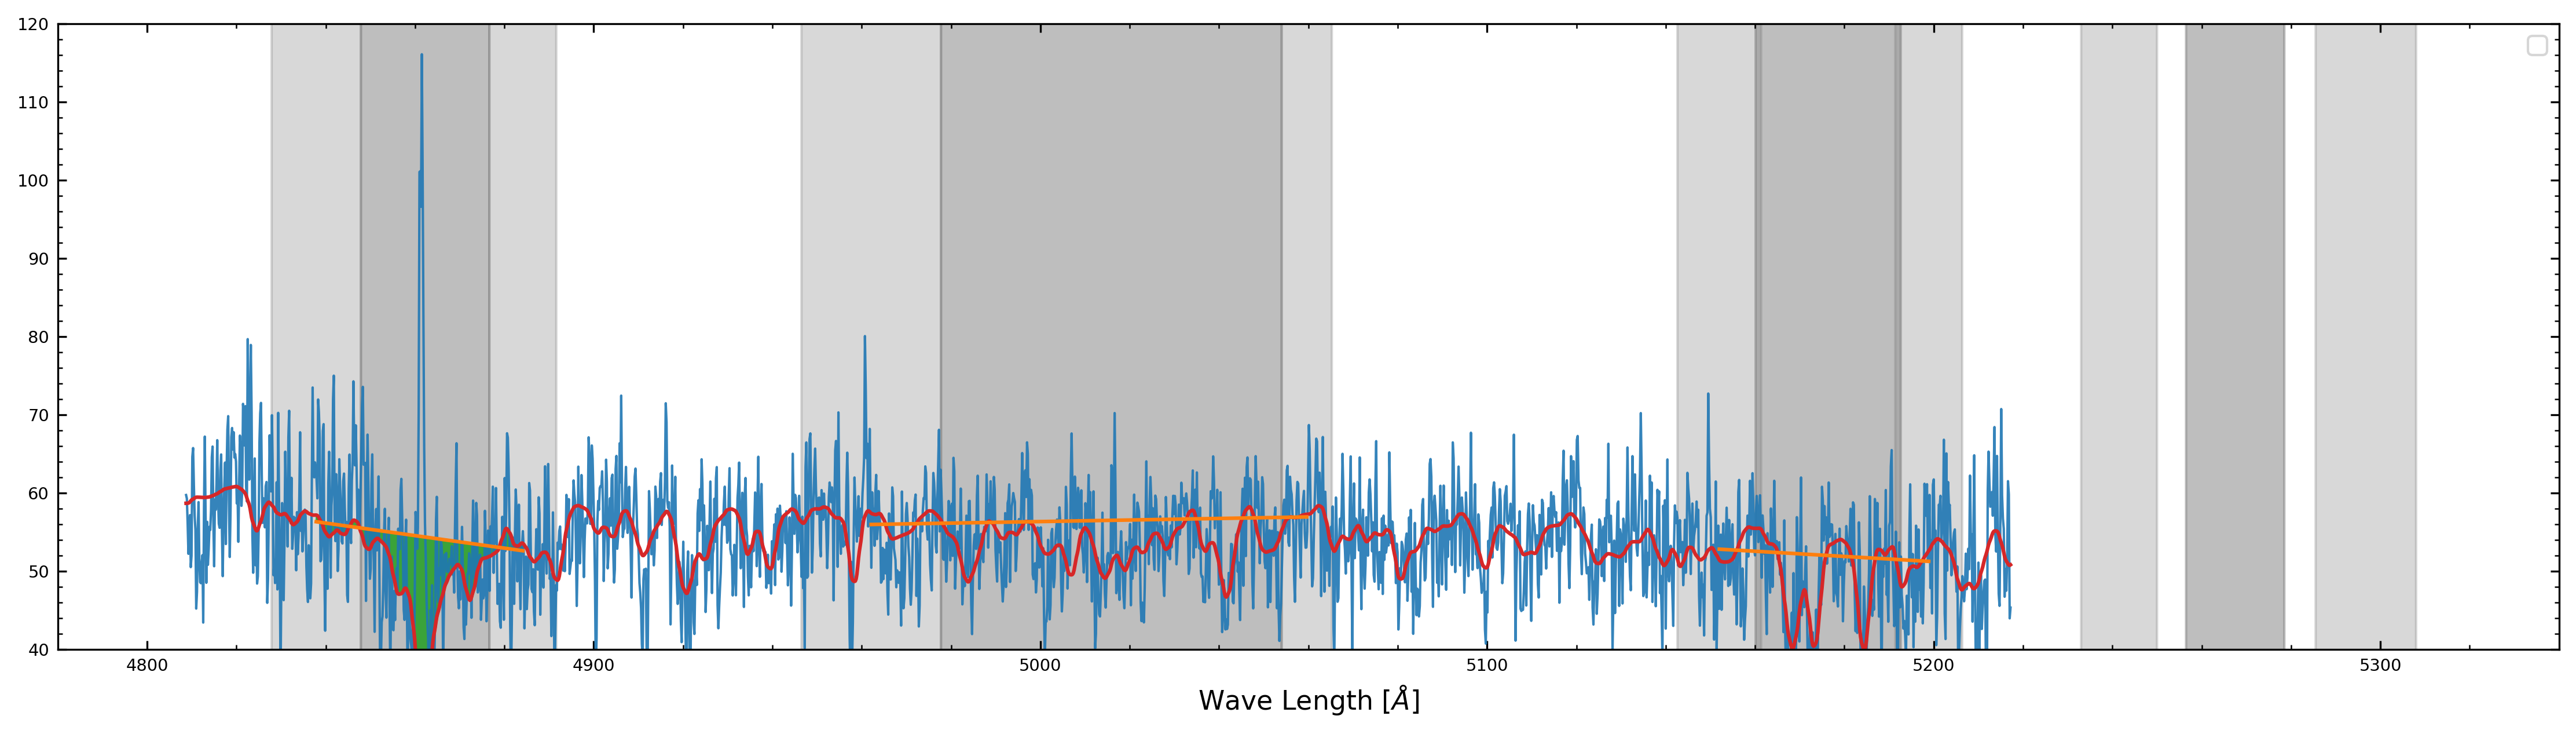

In [123]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,995], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,38], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)

for i in Index_use:
    LP = np.mean([Index_Wave.loc[i,'BPC_range'][0],Index_Wave.loc[i,'BPC_range'][1]])
    RP = np.mean([Index_Wave.loc[i,'RPC_range'][0],Index_Wave.loc[i,'RPC_range'][1]])
    LPV = np.mean(Bestfitfield[:,11,38][ np.where((lam_gal>Index_Wave.loc[i,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'BPC_range'][1])) ])
    RPV = np.mean(Bestfitfield[:,11,38][ np.where((lam_gal>Index_Wave.loc[i,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'RPC_range'][1])) ])
    ax1.plot([LP,RP], [LPV,RPV], lw=1.5, c='tab:orange')

ax1.fill_between(x_wave[:,11,38], y_spectrum[:,11,38], y_SL[:,11,38], color='tab:green', alpha=.9)

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(40,120)
ax1.set_xlim(4780,5340)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

(array([[ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 2

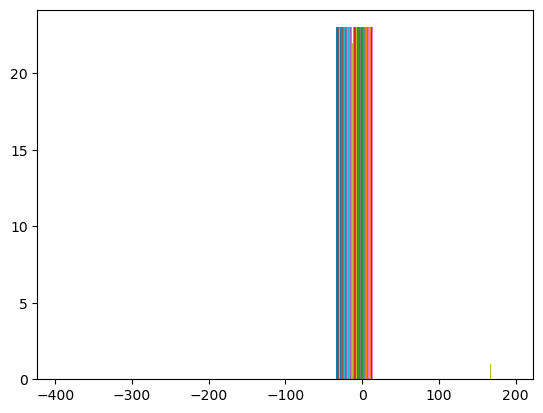

In [124]:
plt.hist(H_Beta_map, range=(-400,200))

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\2614429185.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\2614429185.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\2614429185.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Lo

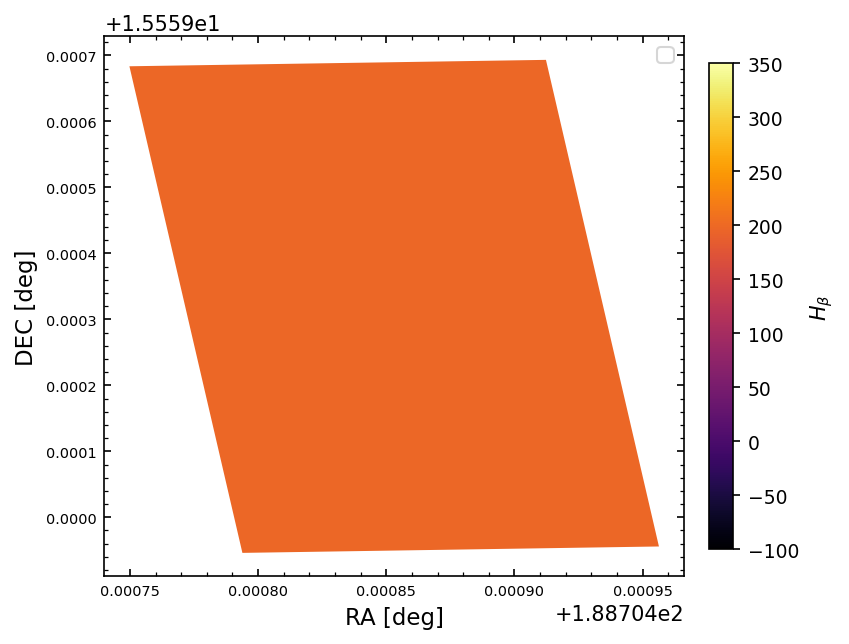

In [125]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = -100
RHS = 350

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(H_Beta_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $')

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\549622776.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\549622776.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('gist_heat')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\549622776.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('gist_heat'))
C:\Users\VacEn-WenJin\AppData\L

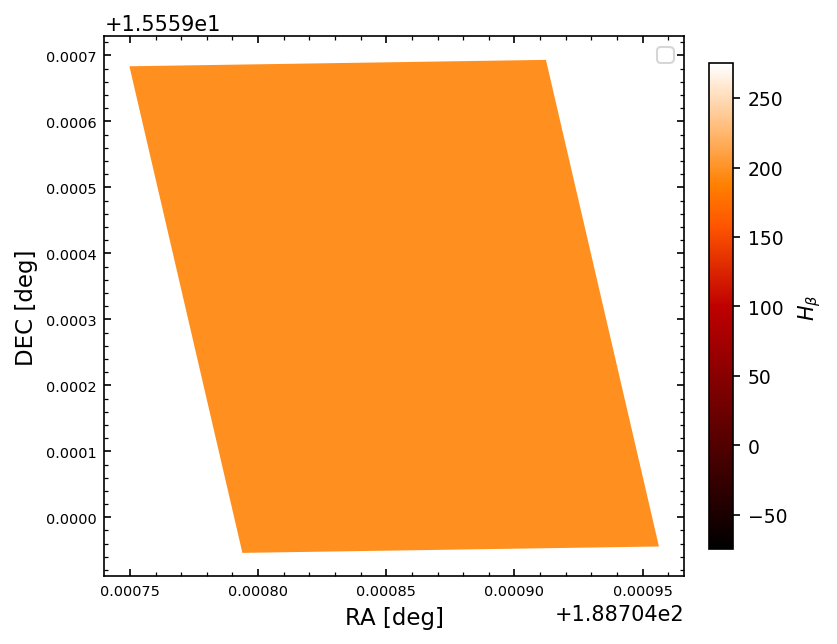

In [126]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = -75
RHS = 275

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('gist_heat')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('gist_heat'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(H_Beta_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $')

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\669906739.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\669906739.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('plasma')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\669906739.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('plasma'))
C:\Users\VacEn-WenJin\AppData\Local\Te

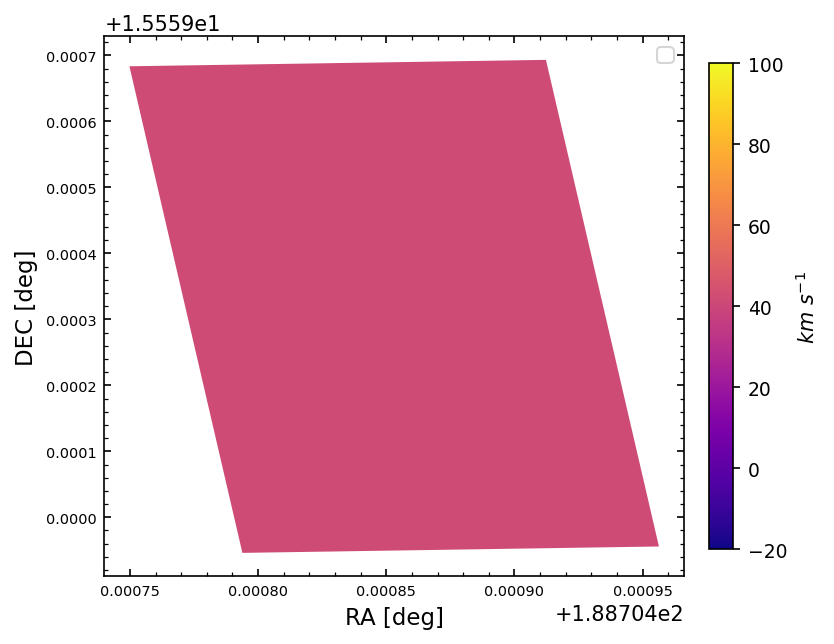

In [127]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = -20
RHS = 100

cm1 = plt.cm.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('plasma'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS and velfield[i,j]<RHS):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(velfield[i,j]))

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#         if(velfield[i,j]<LHS):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='white')
#         if(velfield[i,j]>RHS):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='white')
# ax1.fill

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ km~s^{-1} $')

# plt.savefig('./', format='pdf', bbox_inches='tight')

# Emission line

### set up EL templates

In [128]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, Galaxy_info.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


In [129]:
ngas_comp = 1   # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

In [130]:
gas_names

array(['Hbeta_(1)', '[OIII]5007_d_(1)'], dtype='<U16')

### combine templates

In [131]:
galaxy = Galaxy_info.spectra[:, 995]
noise = np.ones_like(galaxy)

In [132]:
template = optimal_templates[:,11,38]

In [133]:
stars_gas_templates = np.column_stack([template, gas_templates])

## Setup of pPXF input parameters

In [134]:
component = [0] + [1]*2

In [135]:
gas_component=np.array(component) > 0

In [136]:
# moments = [-2, 2, 2, 2]
moments = [-2, 2]
# moments = [-2, 2, 2]

In [137]:
# start = [[V0, sig0], [V1, sig1], [V2, sig2], [V3, sig3]]
ncomp = len(moments)
tied = [['', ''] for _ in range(ncomp)]     # [['', ''], ['', ''], ['', ''], ['', '']]
# tied[2][1] = 'p[3]'                         # sig2 = sig1
# tied[3][0] = '(p[2] + p[4])/2'              # V3 = (V1 + V2)/2

In [138]:
# sig_diff = 200  # minimum dispersion difference in km/s
# A_ineq = np.array([[0, 0, 0, 1, 0, 0, 0, -1],       # sigma2 - sigma4 < -sigma_diff
#                    [0, 0, 0, 0, 0, 1, 0, -1]])      # sigma3 - sigma4 < -sigma_diff
# b_ineq = np.array([-sig_diff, -sig_diff])/Galaxy_info.velscale  # velocities have to be expressed in pixels
# constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}

In [139]:
# start = [[velfield[11,43], sigfield[11,43]],     # The stellar component=0 is fixed and this starting value will remain unchanged
#          [velfield[11,43], 50],            # My starting guess for the velocity of all gas components is the stellar velocity
#          [velfield[11,43], 50],            # however, this starting guess is ignored when using `global_search=True`
#          [velfield[11,43], 500]]           # The starting guess must be feasible, namely must satisfy the constraints

# # use parameters in the first fit.

start = [[velfield[11,38], sigfield[11,38]],
        #  [velfield[11,43], 50],
         [velfield[11,38], 50]]   

In [140]:
# vlim = lambda x: velfield[11,43] + x*np.array([-100, 100])
# bounds = [[vlim(2), [20, 300]],       # Bounds are ignored for the stellar component=0 which has fixed kinematic
#           [vlim(2), [20, 100]],       # I force the narrow component=1 to lie +/-200 km/s from the stellar velocity
#           [vlim(6), [20, 100]],       # I force the narrow component=2 to lie +/-600 km/s from the stellar velocity
#           [vlim(2), [20, 1000]]]      # I force the broad component=3 to lie +/-200 km/s from the stellar velocity

In [141]:
vlim = lambda x: velfield[11,38] + x*np.array([-100, 100])
bounds = [[vlim(2), [20, 300]],       # Bounds are ignored for the stellar component=0 which has fixed kinematic
          [vlim(2), [20, 100]]]      # I force the broad component=3 to lie +/-200 km/s from the stellar velocity

differential_evolution step 1: f(x)= 76411.8
 Best Fit:       Vel     sigma
 comp.  0:        42        20
 comp.  1:         6        22
chi2/DOF: 33.47; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.981       589      97.1
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      589.3       3.3       6    22
Comp:  1      [OIII]5007_d_(1)      129.2       4.2       6    22
-----------------------------------------------------------------


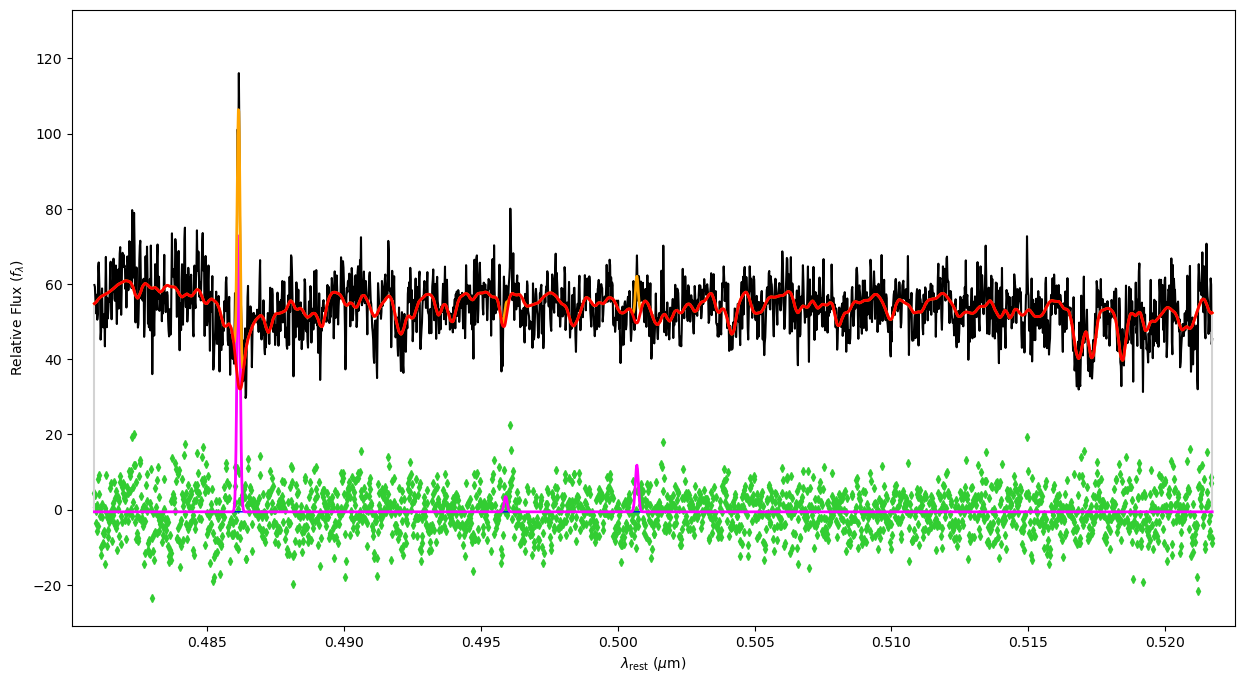

In [142]:
plt.figure(figsize=(15,8))
pp = ppxf(stars_gas_templates, galaxy, noise, Galaxy_info.velscale, start,
          plot=1, moments=moments, degree=8, mdegree=-1, component=component, 
          gas_component=gas_component, gas_names=gas_names, 
        #   constr_kinem=constr_kinem,
          lam=lam_gal, lam_temp=sps.lam_temp, tied=tied, 
          bounds=bounds, 
          global_search=True)

In [143]:
pp.gas_flux

array([589.25749301, 129.15822557])

In [144]:
rms = robust_sigma(galaxy - pp.bestfit, zero=1)

c_kms = 299792.458  # speed of light in km/s
names = ['Hbeta' , '[OIII]5007_d']
for p, name in enumerate(names):
    kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
    print(kk)
    dlam = line_wave[kk]*Galaxy_info.velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
    flux = (pp.gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
    an = np.max(pp.gas_bestfit_templates[:, kk])/rms
    print(f"{name:12s} - Amplitude/Noise: {an:6.4g}; gas flux: {flux:6.0f} ergs/(cm^2 s)")

[ True False]
Hbeta        - Amplitude/Noise:  12.78; gas flux:    104 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  2.161; gas flux:     23 ergs/(cm^2 s)


In [145]:
pp.gas_bestfit_templates.shape

(2249, 2)

In [146]:
Tem_ALL = np.zeros(pp.gas_bestfit_templates.shape[0])

In [147]:
for i in range(2):
    Tem_ALL += pp.gas_bestfit_templates[:,i]
# Tem_ALL += Bestfitfield[:,11,43]
Tem_ALL = pp.bestfit

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\2154086898.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


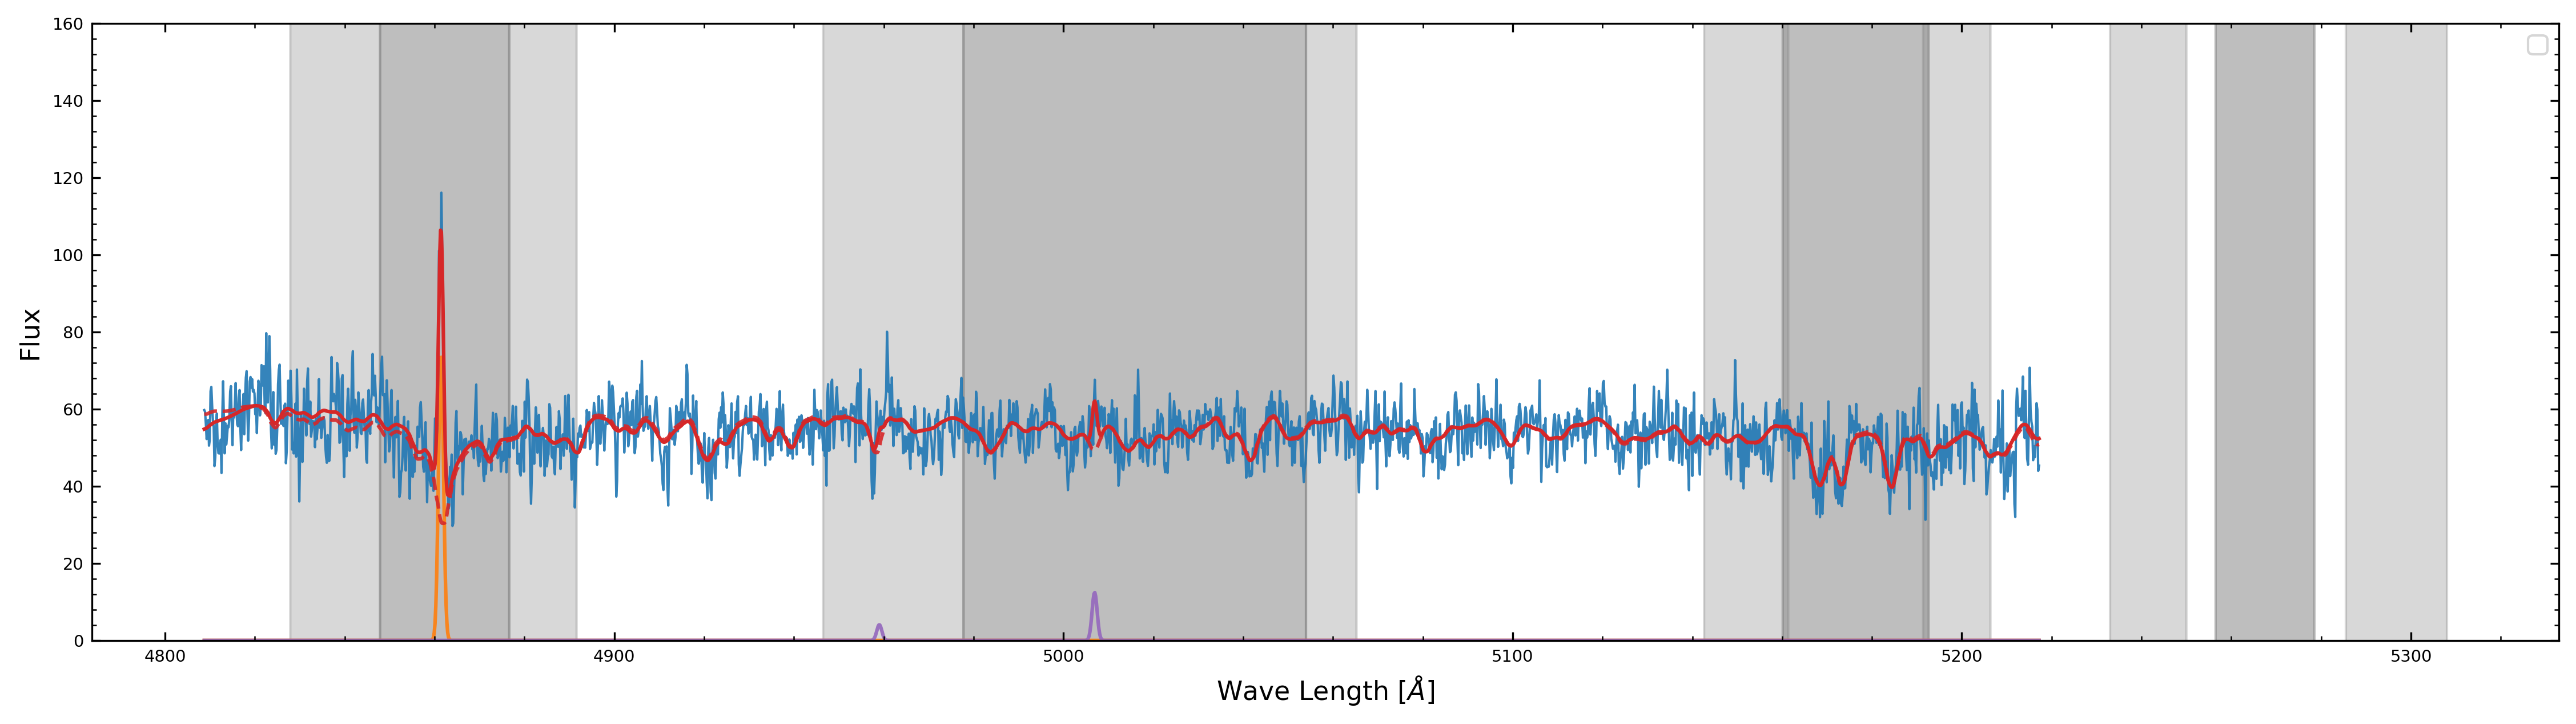

In [148]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,995], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,38], '--', c='tab:red', alpha=.9)

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

# for i in Index_use:
#     LP = np.mean([Index_Wave.loc[i,'BPC_range'][0],Index_Wave.loc[i,'BPC_range'][1]])
#     RP = np.mean([Index_Wave.loc[i,'RPC_range'][0],Index_Wave.loc[i,'RPC_range'][1]])
#     LPV = np.mean(Bestfitfield[:,11,43][ np.where((lam_gal>Index_Wave.loc[i,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'BPC_range'][1])) ])
#     RPV = np.mean(Bestfitfield[:,11,43][ np.where((lam_gal>Index_Wave.loc[i,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'RPC_range'][1])) ])
#     ax1.plot([LP,RP], [LPV,RPV], lw=1.5, c='tab:orange')

for i in [0]:
    ax1.plot(lam_gal, pp.gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

for i in [1]:
    ax1.plot(lam_gal, pp.gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)


ax1.plot(lam_gal,Tem_ALL, '-', c='tab:red')

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(0,160)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.set_ylabel(r'Flux', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\3195854001.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


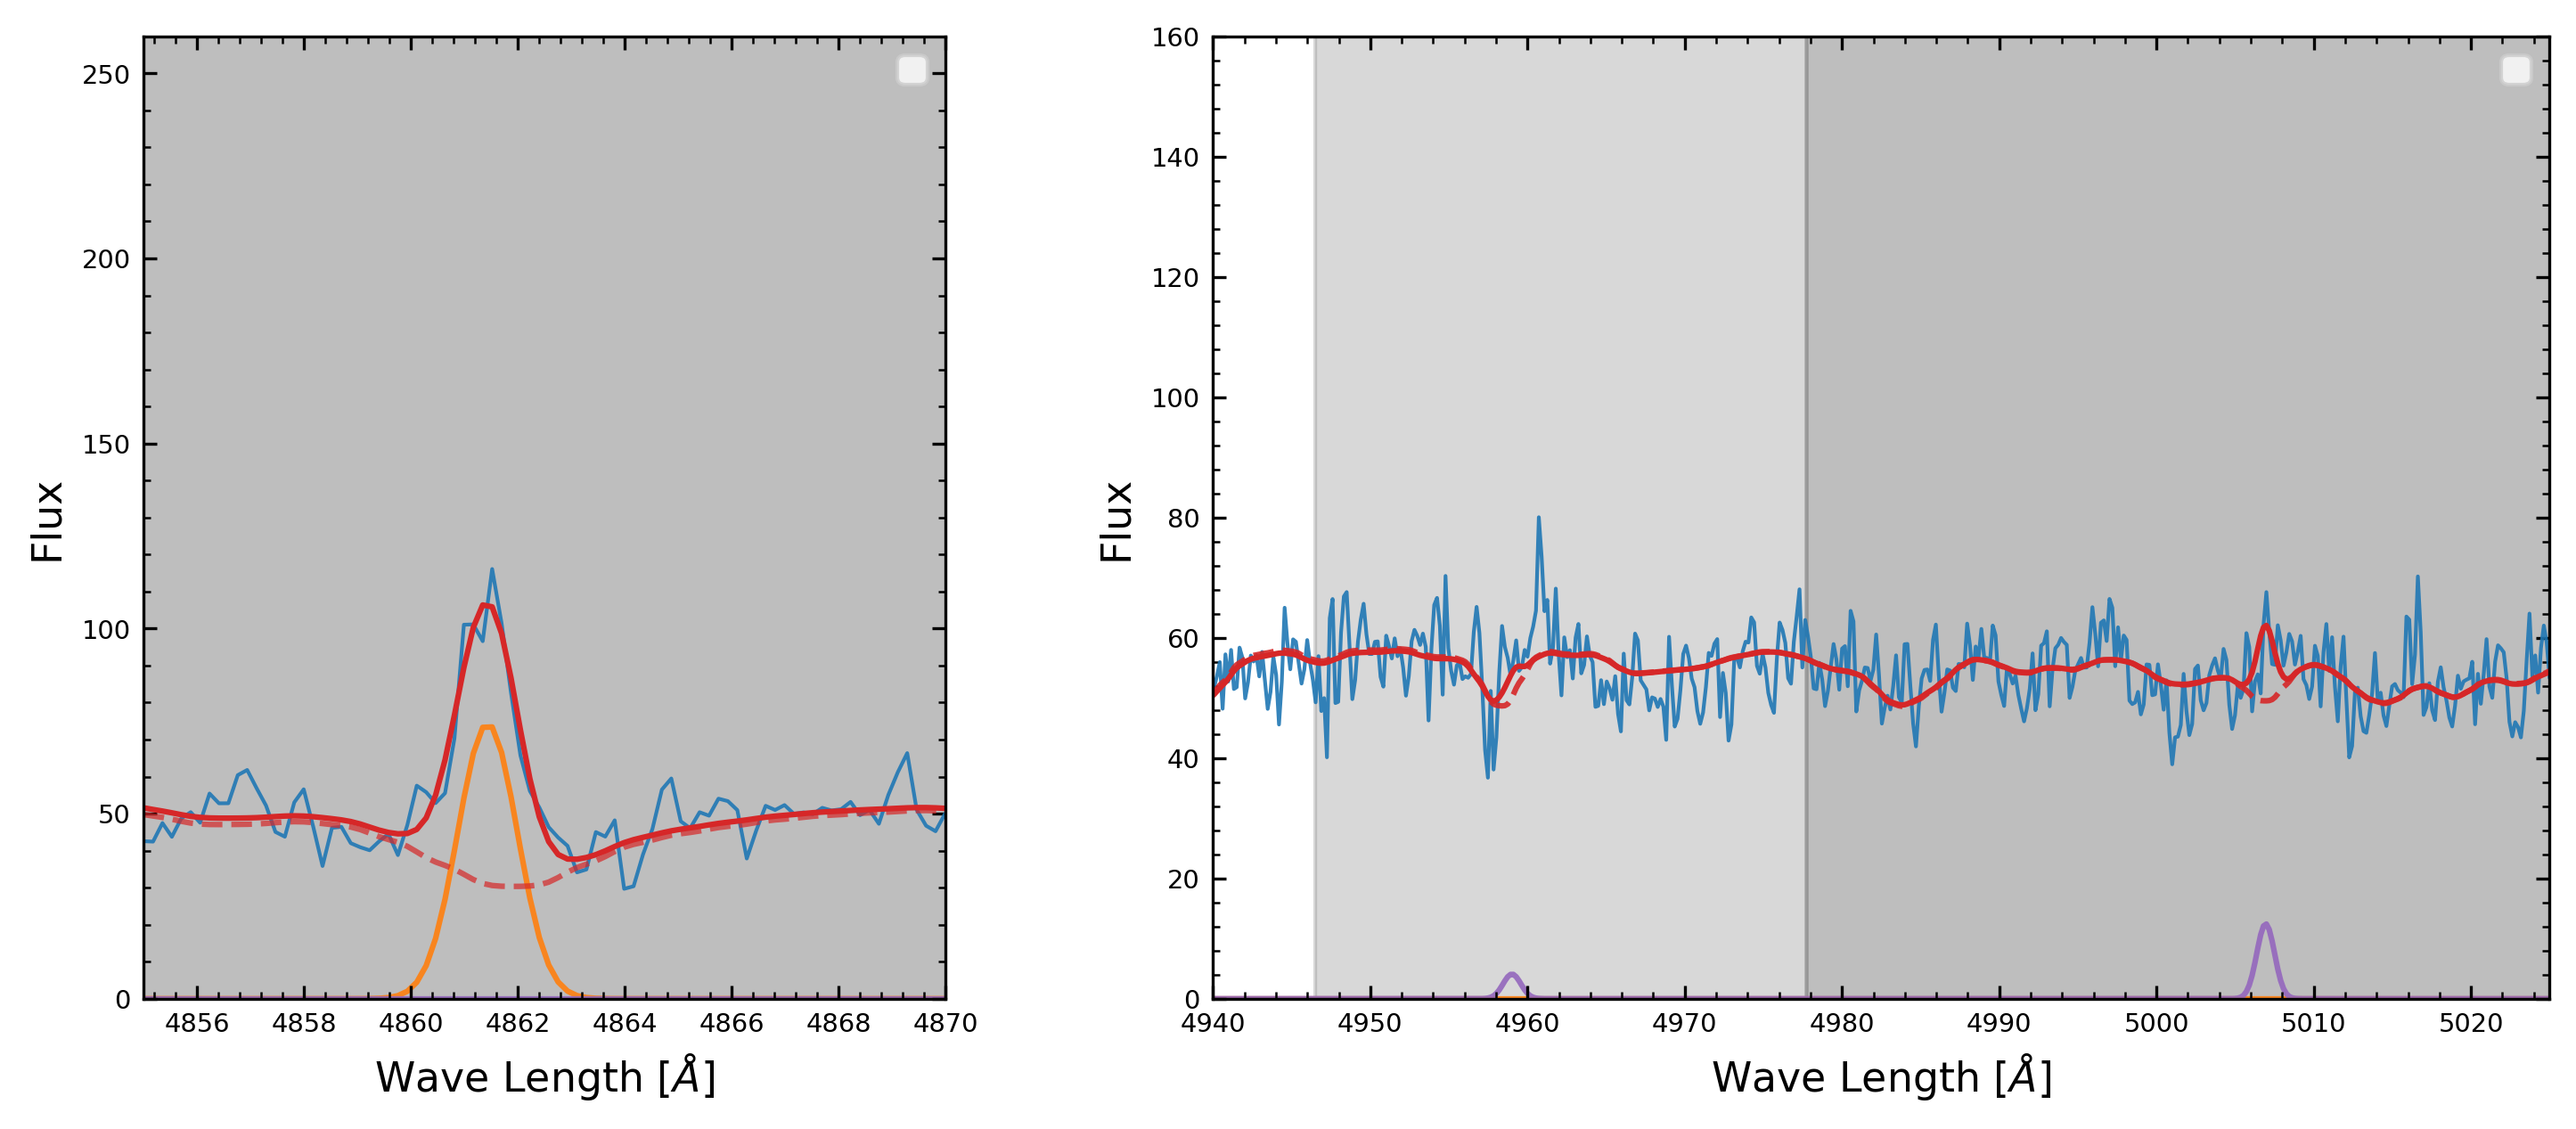

In [149]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(10,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.35, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.45, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax2 = plt.subplot(gs2[0])


# ----------------------------------------------------------------------------------------------------------------

ax1.plot(lam_gal,Galaxy_info.spectra[:,995], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,38], '--', c='tab:red', alpha=.7)


for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

# for i in Index_use:
#     LP = np.mean([Index_Wave.loc[i,'BPC_range'][0],Index_Wave.loc[i,'BPC_range'][1]])
#     RP = np.mean([Index_Wave.loc[i,'RPC_range'][0],Index_Wave.loc[i,'RPC_range'][1]])
#     LPV = np.mean(Bestfitfield[:,11,43][ np.where((lam_gal>Index_Wave.loc[i,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'BPC_range'][1])) ])
#     RPV = np.mean(Bestfitfield[:,11,43][ np.where((lam_gal>Index_Wave.loc[i,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'RPC_range'][1])) ])
#     ax1.plot([LP,RP], [LPV,RPV], lw=1.5, c='tab:orange')

for i in [0]:
    ax1.plot(lam_gal, pp.gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

for i in [1]:
    ax1.plot(lam_gal, pp.gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)


ax1.plot(lam_gal,Tem_ALL, '-', c='tab:red')

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(0,260)
ax1.set_xlim(4855,4870)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.set_ylabel(r'Flux', size=11)
ax1.legend()

# ----------------------------------------------------------------------------------------------------------------

ax2.plot(lam_gal,Galaxy_info.spectra[:,995], c='tab:blue', lw=1, alpha=.9)
ax2.plot(lam_gal,Bestfitfield[:,11,38], '--', c='tab:red', alpha=.9)


for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

# for i in Index_use:
#     LP = np.mean([Index_Wave.loc[i,'BPC_range'][0],Index_Wave.loc[i,'BPC_range'][1]])
#     RP = np.mean([Index_Wave.loc[i,'RPC_range'][0],Index_Wave.loc[i,'RPC_range'][1]])
#     LPV = np.mean(Bestfitfield[:,11,43][ np.where((lam_gal>Index_Wave.loc[i,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'BPC_range'][1])) ])
#     RPV = np.mean(Bestfitfield[:,11,43][ np.where((lam_gal>Index_Wave.loc[i,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[i,'RPC_range'][1])) ])
#     ax1.plot([LP,RP], [LPV,RPV], lw=1.5, c='tab:orange')

for i in [0]:
    ax2.plot(lam_gal, pp.gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

for i in [1]:
    ax2.plot(lam_gal, pp.gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)


ax2.plot(lam_gal,Tem_ALL, '-', c='tab:red')

ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax2.set_xlabel(r'', size=11)
ax2.set_ylabel(r'', size=11)

ax2.set_ylim(0,160)
ax2.set_xlim(4940,5025)
ax2.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax2.set_ylabel(r'Flux', size=11)
ax2.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_34744\1384025090.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


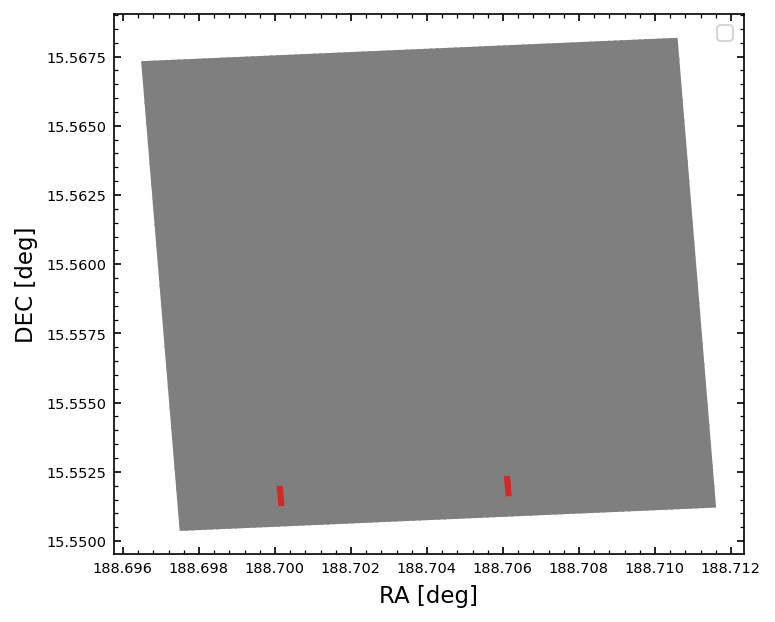

In [150]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = -20
RHS = 100

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(True):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')
        if(i==1):
            if(j==33):
                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:red')
        if(i==1):
            if(j==70):
                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:red')

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#         if(velfield[i,j]<LHS):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='white')
#         if(velfield[i,j]>RHS):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='white')
# ax1.fill

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()


# plt.savefig('./', format='pdf', bbox_inches='tight')